## Approach
Our sixth attempt to improve default results from coursera_lab.ipynb:
- change the GAN training protocol by directly handling derivates using tf.GradientTape()
- inspired by Google tutorial (https://www.tensorflow.org/tutorials/generative/dcgan)
  


----


## Step-by-step instructions 

### Step 1: Data preprocessing 


In [18]:
%%capture
!pip install tensorflow-cpu==2.16.2

# Suppress warnings and set environment variables
import os
import numpy as np
from tensorflow.keras.datasets import mnist
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Suppress all Python warnings
warnings.filterwarnings('ignore')

# Load the MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# Normalize the pixel values to the range [-1, 1]
x_train = x_train.astype('float32') / 127.5 - 1.
x_train = np.expand_dims(x_train, axis=-1)


### Step 2: Building the model


In [19]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input 

# Define the generator model 
def build_generator(): 
    model = Sequential() 
    model.add(Dense(256, input_dim=100)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(1024)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    
    #added this
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    ###
    
    model.add(Dense(28 * 28 * 1, activation='tanh')) 
    model.add(Reshape((28, 28, 1))) 
    return model 

# Define the discriminator model 
def build_discriminator(): 
    model = Sequential() 
    model.add(Flatten(input_shape=(28, 28, 1))) 

#    model.add(Dense(512)) 
#    model.add(LeakyReLU(alpha=0.2)) 

    model.add(Dense(256)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(1, activation='sigmoid')) 
    return model 


# Build and compile the generator 
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build and compile the discriminator
discriminator = build_discriminator() 
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 


### Step 3: Training the GAN 

#### Objective: 
- Train the GAN on the MNIST dataset. 


In [20]:
import tensorflow as tf
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss 
    return total_loss


# Training parameters 

batch_size = 64
epochs = 5000
sample_interval = 10

# Adversarial ground truths 
real = np.ones((batch_size, 1)) 
fake = np.zeros((batch_size, 1)) 

# Training loop 
for epoch in range(epochs): 
    # Train the discriminator 
    idx = np.random.randint(0, x_train.shape[0], batch_size) 
    real_images = x_train[idx] 
    noise = np.random.normal(0, 1, (batch_size, 100)) 
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) 

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # Print the progress 
    if epoch % sample_interval == 0: 
        print(f"{epoch} [D loss: {disc_loss}]  [G loss: {gen_loss}]")


0 [D loss: 2.16219425201416]  [G loss: 1.3572932481765747]
10 [D loss: 0.5103753805160522]  [G loss: 1.0419645309448242]
20 [D loss: 0.6510750651359558]  [G loss: 0.8042455911636353]
30 [D loss: 0.7649405598640442]  [G loss: 0.676344096660614]
40 [D loss: 0.9108326435089111]  [G loss: 0.5535261631011963]
50 [D loss: 1.1027854681015015]  [G loss: 0.44256919622421265]
60 [D loss: 1.2123123407363892]  [G loss: 0.39279085397720337]
70 [D loss: 1.238000750541687]  [G loss: 0.378874272108078]
80 [D loss: 1.2271080017089844]  [G loss: 0.37382733821868896]
90 [D loss: 1.2956316471099854]  [G loss: 0.34026071429252625]
100 [D loss: 1.210936427116394]  [G loss: 0.3737682104110718]
110 [D loss: 1.1397491693496704]  [G loss: 0.41039180755615234]
120 [D loss: 1.1451573371887207]  [G loss: 0.4099317193031311]
130 [D loss: 1.0450072288513184]  [G loss: 0.46935170888900757]
140 [D loss: 1.0319623947143555]  [G loss: 0.47164008021354675]
150 [D loss: 1.0140485763549805]  [G loss: 0.48487430810928345]
1

### Step 4: Assessing the Quality of Generated Images 

### Objective: 
- Evaluate the performance of the trained GAN. 

### 1. Qualitative Assessment: Visual Inspection


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


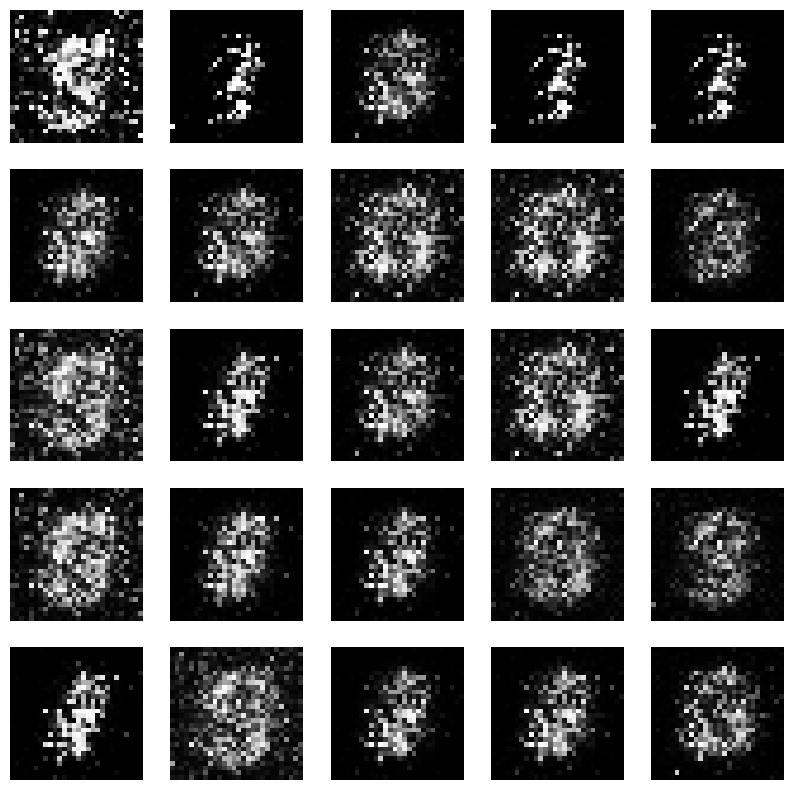

In [21]:
!pip install matplotlib
import matplotlib.pyplot as plt 

def sample_images(generator, epoch, num_images=25): 
    noise = np.random.normal(0, 1, (num_images, 100)) 
    generated_images = generator.predict(noise) 
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1] 
    fig, axs = plt.subplots(5, 5, figsize=(10, 10)) 
    count = 0 

    for i in range(5): 
        for j in range(5): 
            axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray') 
            axs[i, j].axis('off') 
            count += 1 
    plt.show() 

# Sample images at the end of training 
sample_images(generator, epochs)



### 2. Quantitative Assessment: Metrics


In [22]:
# Calculate and print the discriminator accuracy on real vs. fake images
noise = np.random.normal(0, 1, (batch_size, 100))
generated_images = generator.predict(noise)

# Evaluate the discriminator on real images
real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
d_loss_real = discriminator.evaluate(real_images, np.ones((batch_size, 1)), verbose=0)

# Evaluate the discriminator on fake images
d_loss_fake = discriminator.evaluate(generated_images, np.zeros((batch_size, 1)), verbose=0)

print(f"Discriminator Accuracy on Real Images: {d_loss_real[1] * 100:.2f}%")
print(f"Discriminator Accuracy on Fake Images: {d_loss_fake[1] * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
Discriminator Accuracy on Real Images: 71.88%
Discriminator Accuracy on Fake Images: 67.19%


# Summary of results 

### - GAN architecture no longer gets stuck! 
### - Loss functions of generator and discriminator fluctuate up and down throughout the course of training.
### - After training for more than 5000 epochs, images visually start to resemble numbers. 
### - At least the central regions accumulate white pixels corresponding to the number and the surrounding background regions become black.



- Interesting to note that Google's GAN tutorial uses CNNs in both their generator and discriminator. They achieve better generator images that look like numbers with fewer epochs of training, but more trainable parameters.

| Number of params  | my GAN (DNN) | Google's GAN (CNN) |
| :---------------- | :------: | :----: |
| Generator         |   1,614,352   | 2,305,472 |
| Discriminator     |   201,217   | 212,865 |

